In [1]:
#!pip install sentencepiece

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path_to_dataset = "C:/Users/USER/Desktop/AIFFEL/work/transformer_chatbot/data"
path_to_chatbot = os.path.join(path_to_dataset, 'ChatbotData.csv')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

data = pd.read_csv(path_to_chatbot)
data.sample(10)

,Q,A,label
2029,버림 받은 느낌,아닐거예요.,0
5680,그만 힘들어하구 싶다,그랬었지 하고 추억하는 날이 올 거예요.,1
9585,다니던 회사를 그만두고 1년간 여행을 가자고 해.,큰 용기가 필요하겠네요.,2
5846,남친과 헤어진지 12일째.,얼마 안 됐네요.,1
2806,싸게 팔길래 샀어,득템 했네요.,0
2550,손목 아프다구,스트레칭해주세요.,0
6360,무슨마음일까,사람 마을은 알기 힘들어요.,1
3464,왼손잡이가 잘못이야?,절대 아니죠.,0
1232,대학원 가고 싶어,꿈에 도전하는 건 좋은 거라고 들었어요.,0
9837,사내 썸 뭔가 떨린다.,저도 떨리네요.,2


In [4]:
#데이터 분석 함수
#===============================================================================================================================#
def below_threshold_len(max_len, data, features):
    max_len_list = []
    # 두 입력의 길이가 맞지 않다면 맞춰주기
    if len(max_len) < len(features):
        max_len_list = [max_len for _ in range(len(features) - len(max_len))]
    elif len(max_len) > len(features):
        max_len_list = max_len[:len(features)]
    else:
        max_len_list = max_len
    
    for idx, feature in enumerate(features):
        cnt=0
        for s in data[feature]:
            if(len(s.split())<=max_len_list[idx]):
                cnt = cnt+1
        print('전체 %s 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(feature ,max_len_list[idx], (cnt / len(data[feature]))))

#데이터 길이 시각화 함수
def DataLengthVisualization(data, features, bins=40):
    
    #가변 길이 처리하기위한 dictionary
    container = dict()

    for idx, feature in enumerate(features):
        container[feature] = [len(s.split()) for s in data[feature]]
    
        print('{}의 최소 길이 : {}'.format(feature, np.min(container[feature])))
        print('{}의 최대 길이 : {}'.format(feature, np.max(container[feature])))
        print('{}의 평균 길이 : {}'.format(feature, np.mean(container[feature])))
    
        plt.subplot(1,len(features),idx+1)
        plt.boxplot(container[feature])
        plt.title(feature)
        
    plt.tight_layout()
    plt.show()

    for idx, feature in enumerate(features):
    
        plt.title(feature)
        plt.hist(container[feature],bins=bins)
        plt.xlabel('length of samples')
        plt.ylabel('number of samples')
        plt.show()

#희귀 단어 파악
def spase_word(data, features, threshold=7):

    #가변 길이 처리하기위한 dictionary
    container = dict()
    
    for feature in features:
        container[feature] = data[feature].tolist()
        
        # 단어 빈도수 계산
        word_counter = Counter()
        for text in container[feature]:
            word_counter.update(text.split())
        
        total_cnt = len(word_counter)  # 전체 단어 개수
        total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
        rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
        rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수
        
        # 희귀 단어를 제외한 단어 사전 구축
        vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
        word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

        print('대상 feature : ', feature)
        print('단어 집합(vocabulary)의 크기 :', total_cnt)
        print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
        print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
        print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
        print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
        print("=======================================================================")

In [24]:
# 데이터 전처리
#==========================================================================================================================================================================
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for

    sentence = sentence.strip()
    return sentence

def preprocessing(data, features, corpus_file, max_samples = 40000):
    data.drop_duplicates(subset=features[0], inplace=True)
    if data.isnull().sum().sum() > 0:
        data.dropna(axis=0, inplace=True)
    for feature in features:
        data[feature] = data[feature].apply(preprocess_sentence)

    corpus_file = corpus_file
    with open(corpus_file, 'w', encoding='utf-8') as f:
        for q,a in zip(data[features[0]], data[features[1]]):
            f.write(q + "\n")
            f.write(a + "\n")
    if data.shape[0] < max_samples:
        return data[features]
    else:
        return data[features].iloc[:max_samples]

In [6]:
# dataset 정의
#========================================================================================================================================================================

class CustomDataset(Dataset):
    def __init__(self, data, sp, max_length=40, features=None):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        if features is None:
            features = data.columns[:2]

        for q_text,a_text in zip(data[features[0]], data[features[1]]):
            # 1) tokenize
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input":q_tokens,
                "dec_input":dec_input,
                "target":target,
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

In [7]:
#Transformer model 설계
#============================================================================================================================================================================

def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x==0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)  -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 **((2.0 * (i // 2))/d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(device)

def scaled_dot_product_attention(query, key, value, mask=None):
    
    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk=torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1) # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    # 아주 작은 값이 더해지면 e^(logit+epsilon) 가 되기 때문에 e^logit * e^epsilon 이 되어 무시할 수 있는 값이 됨
    if mask is not None:
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        output = self.out_dense(concat_attention)
        return output

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2

class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 units,
                 d_model,
                 num_heads,
                 dropout=0.1):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            vocab_size = vocab_size,
            num_layers = num_layers,
            ff_dim = units,
            d_model = d_model,
            num_heads = num_heads,
            dropout = dropout
        )

        self.decoder = Decoder(
            vocab_size = vocab_size,
            num_layers = num_layers,
            ff_dim = units,
            d_model = d_model,
            num_heads = num_heads,
            dropout = dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs) # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs) # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs) # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x = inputs,
            mask = enc_padding_mask
        ) # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x = dec_inputs,                     # (batch_size, tgt_seq_len)
            enc_outputs = enc_outputs,          # (batch_size, src_seq_len, d_model)
            look_ahead_mask = look_ahead_mask,
            padding_mask = dec_padding_mask,
        ) # shape: (batch_size, tgt_seq_len, d_model)

        logits = self.final_linear(dec_outputs) # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [8]:
# 시각화 및 보조 함수/ 기타
#=================================================================================================================================================================================

def Loss_Visualization(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses, 'b-',label='Train Loss')
    plt.plot(range(len(val_losses)), val_losses,'r--', label='Validation Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.show()

def Acc_Visualization(train_acc, val_acc):
    plt.plot(range(len(train_acc)), train_acc, 'b-',label='Train Acc')
    plt.plot(range(len(val_acc)), val_acc,'r--', label='Validation Acc')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.title("Training and Validation Acc")
    plt.show()

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

def get_lr_lambda(d_model, warmup_steps = 4000):
    d_model = float(d_model)
    def lr_lambda(step):
        step += 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))

    return lr_lambda

# 학습 함수
#=======================================================================================================================================================================

def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]
    
    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input) # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target) # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

def eval_step(model, batch, loss_function, device):
    model.eval()
    enc_input, dec_input, target = [x.to(device) for x in batch]
    
    # 모델 포워드 패스
    logits = model(enc_input, dec_input) # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target) # (batch_size, vocab_size, seq_len) 필요

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

def train_model(model, train_dataset,vocab_size=8000, 
                num_layers=2, units=512, d_model=256,
                num_heads=8, dropout=0.1, train_ratio=0.8,
                warmup_steps=4000, criterion = 'CE', optimize='Adam',
                batch_size=256, epochs=50,lr = 0.001, 
                verbose = 1, patience=4, max_len = 40):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model(
        vocab_size=vocab_size,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT
    )
    
    model.to(device)
    
    # 손실 함수 & 옵티마이저
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
    
    if optimize=='AdamW':
        optimizer=optim.AdamW(model.parameters(), lr=lr)
    elif optimize=='Adam':
        optimizer=optim.Adam(model.parameters(), betas = (0.9, 0.98), eps=1e-9, lr=lr)
    elif optimze=="SGD":
        optimizer=optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer=optim.Adam(model.parameters(), betas = (0.9, 0.98), eps=1e-9, lr=lr)

    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = get_lr_lambda(d_model, warmup_steps = 4000))

    train_losses = []
    val_losses = []
    train_acc_list = []
    val_acc_list = []

    train_size = int(len(train_dataset) * train_ratio)
    val_size = len(train_dataset) - train_size
    
    # 랜덤하게 dataset나누기
    tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
        
    model.train()
    best_param = dict()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss, total_acc = 0, 0

        # PyTorch DataLoader 설정. epoch 마다 train과 test 에서   
        train_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            loss, acc = train_step(model, batch, optimizer, criterion, device)
            total_loss += loss
            total_acc += acc

            if (step+1) % (verbose*100) == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_acc / len(train_loader)
        train_losses.append(avg_loss)
        train_acc_list.append(avg_acc.to('cpu'))
        
        # Validation loss 계산
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                loss, acc = eval_step(model, batch, criterion, device)

                val_loss += loss
                val_acc += acc

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc /= len(val_loader)
        val_acc_list.append(val_acc.to('cpu'))
        
        if (epoch+1)%verbose==0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_param = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

    model.load_state_dict(best_param)
        
    Loss_Visualization(train_losses, val_losses)
    Acc_Visualization(train_acc_list, val_acc_list)
    return model

In [9]:
# 추론 함수
# ==============================================================================================================================

def decoder_inference(model, sentence, tokenizer, device="cpu"):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40
    
    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]

    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0) # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist() # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

def sentence_generation(model, sentence, tokenizer, device='cpu'):
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )
    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [10]:
MAX_SAMPLES = 50000
corpus_file = "clean_corpus_project.txt"
data_preprocessing = preprocessing(data.copy(), features=["Q","A"], corpus_file= "clean_corpus_project.txt", max_samples = 50000)
data_preprocessing.sample(10)

,Q,A
3042,어렸을때 공부할껄,원래 못하면 하고 싶어지죠 .
1417,또라이들 짱 많아,세상에는 별의별 사람들이 있어요 .
4363,집안일 어려워,조금씩 잘 하게 될거예요
837,내가 많이 부족한가,잘하는 게 다른 거예요 .
2745,시험 공부 큰일,지금도 늦지 않았어요 .
4034,저녁 메뉴 좀 골라줘,맛있는 거 드세요 .
2151,부모님이 선 보래,많이 만나보세요 .
9264,남자는 좋아하는 여자랑 눈 마주치면 어떻게 해 ?,당황해서 제대로 눈을 못 볼 것 같아요 .
1502,만나기만 하면 자꾸 싸우게돼,성격이 안 맞나봐요 .
6402,미치겠습니다 연락하고 싶어서,연락하고 나면 더 힘들 거예요 .


In [11]:
data_preprocessing.shape

(11662, 2)

Q의 최소 길이 : 1
Q의 최대 길이 : 16
Q의 평균 길이 : 3.9477791116446577
A의 최소 길이 : 1
A의 최대 길이 : 24
A의 평균 길이 : 4.720802606756989


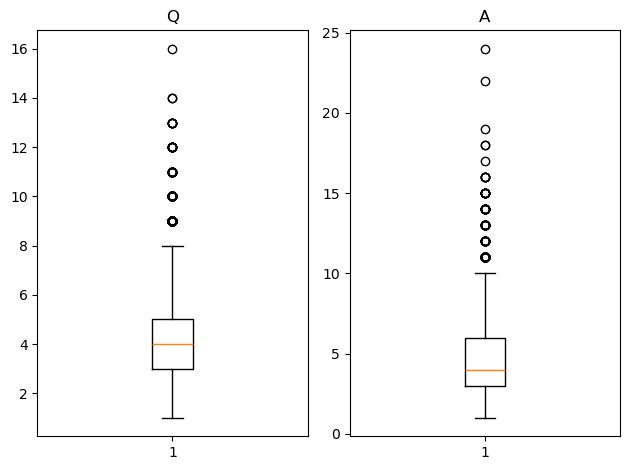

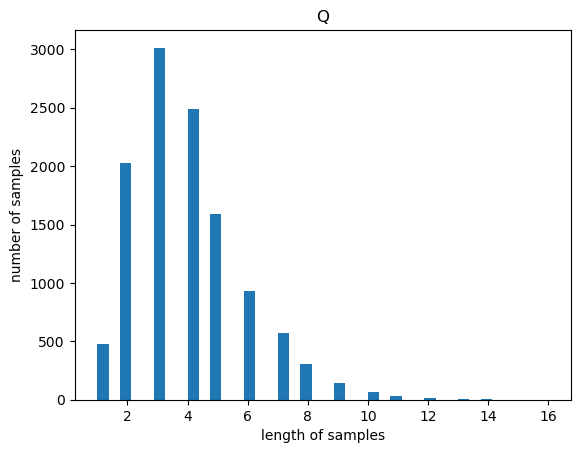

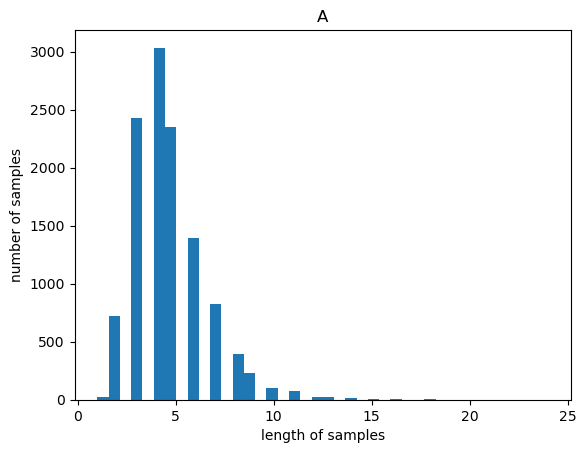

In [12]:
DataLengthVisualization(data_preprocessing,['Q', 'A'])

In [13]:
# max_len 정하기
MAX_LEN = 8
below_threshold_len([MAX_LEN, MAX_LEN],data,['Q', 'A'])

전체 Q 샘플 중 길이가 8 이하인 샘플의 비율: 0.9904423581155375
전체 A 샘플 중 길이가 8 이하인 샘플의 비율: 0.9802926499196482


In [14]:
# SentencePiece/ tokenization
        
spm.SentencePieceTrainer.Train(
    input = corpus_file,
    model_prefix="spm_cornell",
    vocab_size=8000,
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length = 999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3   # Unknown Token ID 설정
)
sp = spm.SentencePieceProcessor()
sp.Load("spm_cornell.model")

True

In [15]:
# dataset 생성
# max_len을 생성할때와 맞추기로 결정
MAX_LEN = 40
dataset = CustomDataset(data_preprocessing, sp, max_length=MAX_LEN, features = ['Q', 'A'])

In [16]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 8                   # 인코더/디코더 층 수
D_MODEL = 512                    # 임베딩 및 내부 표현 차원
NUM_HEADS = 16                   # 멀티헤드 어텐션에서의 헤드 수
UNITS = 4096                     # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1                    # 드롭아웃 비율
VOCAB_SIZE = sp.get_piece_size() # 단어 집합 크기(예시)
WARMUP_STEPS = 4000
BATCH_SIZE = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Using device: cuda
Epoch 100/10000 | Train Loss: 6.1030, Train Acc: 0.3033 | Val Loss: 6.0765, Val Acc: 0.3118
Epoch 200/10000 | Train Loss: 5.4989, Train Acc: 0.3182 | Val Loss: 5.6049, Val Acc: 0.3216
Epoch 300/10000 | Train Loss: 5.1685, Train Acc: 0.3335 | Val Loss: 5.3727, Val Acc: 0.3319
Epoch 400/10000 | Train Loss: 4.9476, Train Acc: 0.3449 | Val Loss: 5.2307, Val Acc: 0.3405
Epoch 500/10000 | Train Loss: 4.7799, Train Acc: 0.3551 | Val Loss: 5.1316, Val Acc: 0.3474
Epoch 600/10000 | Train Loss: 4.6442, Train Acc: 0.3650 | Val Loss: 5.0562, Val Acc: 0.3512
Epoch 700/10000 | Train Loss: 4.5288, Train Acc: 0.3751 | Val Loss: 4.9951, Val Acc: 0.3565
Epoch 800/10000 | Train Loss: 4.4253, Train Acc: 0.3856 | Val Loss: 4.9431, Val Acc: 0.3587
Epoch 900/10000 | Train Loss: 4.3331, Train Acc: 0.3943 | Val Loss: 4.8985, Val Acc: 0.3622
Epoch 1000/10000 | Train Loss: 4.2517, Train Acc: 0.4033 | Val Loss: 4.8583, Val Acc: 0.3652
Epoch 1100/10000 | Train Loss: 4.1743, Train Acc: 0.4107 | V

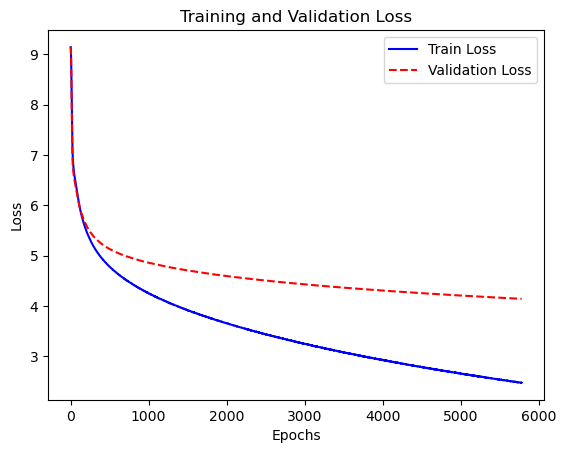

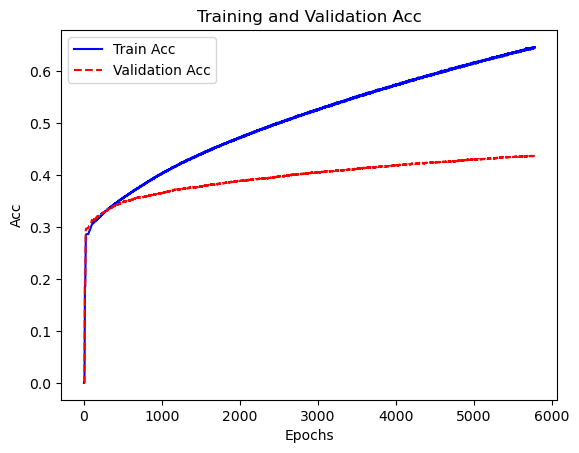

In [17]:
# 모델 학습
model = train_model(Transformer, dataset, vocab_size=VOCAB_SIZE, 
                num_layers=NUM_LAYERS, units=UNITS, d_model=D_MODEL,
                num_heads=NUM_HEADS, dropout=DROPOUT, warmup_steps=WARMUP_STEPS, 
                batch_size=BATCH_SIZE, epochs=10000,lr = 0.001, verbose = 100, train_ratio=0.9,
                patience=6)

In [18]:
# 데이터 내 문장 (짧은 문장)
sentence = '놀고 싶다.'
sentence_generation(model, sentence, sp, device)

입력 : 놀고 싶다.
출력 : 저도 같이 가요 .


'저도 같이 가요 .'

In [19]:
# 데이터 내 문장 (긴 문장)
sentence = '썸을 오래 탔는데 사귀어도 괜찮은 사람일까?'
sentence_generation(model, sentence, sp, device)

입력 : 썸을 오래 탔는데 사귀어도 괜찮은 사람일까?
출력 : 직접 물어보는 게 좋을 것 같아요 .


'직접 물어보는 게 좋을 것 같아요 .'

In [20]:
# 데이터 내 문장 2개 합성
sentence = '내 여자친구 아이돌이야. 여자친구가 너무 예뻐'
sentence_generation(model, sentence, sp, device)

입력 : 내 여자친구 아이돌이야. 여자친구가 너무 예뻐
출력 : 이제 좀 더 버텨보세요 .


'이제 좀 더 버텨보세요 .'

In [21]:
# 데이터 내 문장 단어 대체
sentence = '사과 먹고 싶다.'
sentence_generation(model, sentence, sp, device)

입력 : 사과 먹고 싶다.
출력 : 너무 무리하지 마세요 .


'너무 무리하지 마세요 .'

In [22]:
# 데이터 외 문장
sentence = '인공지능이 흥미로워'
sentence_generation(model, sentence, sp, device)

입력 : 인공지능이 흥미로워
출력 : 그게 제일 힘들어요 .


'그게 제일 힘들어요 .'

Train loss와 validation loss를 나누어 early stopping 조건을 만들어서 시도해 보았습니다. 하지만, Tranasformer 모델은 unseem data도 잘 예측하여 계속해서 loss가 감소하였습니다. 이전 실험에서 3000정도에 early stopping이 되었기 때문에 4000 정도로 다시 실험하였습니다. 실험은 위와 같이 "데이터 내 문장 (짧은 문장)","데이터 내 문장 (긴 문장)","데이터 내 문장 2개 합성", "데이터 내 문장 단어 대체", "데이터 외 문장" 이렇게 5개의 타입의 문장에 대하여 예측하였습니다.